# Capstone project 

## Introduction: Business Problem

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted 
to stakeholders interested in opening a restaurant in London, England.

Here we will try to find if someone wants to open a new restaurant in the city, then which location is best suited for it 
keeping in mind the competitors and which income group of people will be attracted most to it based on the population of the 
neighbourhood.

Since there are lots of restaurants in London we will try to detect locations that are not already crowded with restaurants.
We would also prefer locations as close to city center as possible, assuming that first two conditions are met.

We will use data science tools and methodology to generate the most promissing neighborhoods based on this criteria. 
Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data

Based on definition of our problem, factors that will influence our decission are:

    *All existing restaurants in the neighborhood (any type of restaurant)
    *Age group of people with their income
    *Distance of neighborhood from city center
We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:

    *centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using
    https://en.wikipedia.org/wiki/List_of_areas_of_London
    *number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API

Preparing the envirement:

In [1]:
#install libraries 
#!pip install geopy    
#!pip install folium   
#!pip install geocoder

In [2]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [3]:
import pandas as pd
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans

### Package breakdown:

Pandas : To collect and manipulate data in JSON and HTMl and then data analysis

requests : Handle http requests

matplotlib : Detailing the generated maps

folium : Generating maps of London and Paris

sklearn : To import K means which is the machine learning model that we are using.

### 1. Download and Explore Dataset

In the data collection stage, we begin with collecting the required data for the cities of London

In [4]:
url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
wiki_london_url = requests.get(url_london)
wiki_london_data = pd.read_html(wiki_london_url.text)
wiki_london_data = wiki_london_data[1]
wiki_london_data.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [5]:
list(wiki_london_data.columns)

['Location',
 'London\xa0borough',
 'Post town',
 'Postcode\xa0district',
 'Dial\xa0code',
 'OS grid ref']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'town','Postal_Code'] 

# instantiate the dataframe
london = pd.DataFrame(columns=column_names)
london['Borough'] = wiki_london_data['London\xa0borough']
london['town'] = wiki_london_data['Post town']
london['Postal_Code'] = wiki_london_data['Postcode\xa0district']
london.head(11)

,Borough,town,Postal_Code
0,"Bexley, Greenwich [7]",LONDON,SE2
1,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Croydon[8],CROYDON,CR0
3,Croydon[8],CROYDON,CR0
4,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
5,Redbridge[9],ILFORD,IG2
6,City[10],LONDON,EC3
7,Westminster[10],LONDON,WC2
8,Brent[11],WEMBLEY,HA0
9,Bromley[11],LONDON,SE20


In [7]:
london.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
london['Borough'] = london['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
london.head(11)

,Borough,town,Postal_Code
0,"Bexley, Greenwich",LONDON,SE2
1,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Croydon,CROYDON,CR0
3,Croydon,CROYDON,CR0
4,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
5,Redbridge,ILFORD,IG2
6,City,LONDON,EC3
7,Westminster,LONDON,WC2
8,Brent,WEMBLEY,HA0
9,Bromley,LONDON,SE20


We can only focusing on the neighbourhoods of London, so performing the changes

In [8]:
london = london[london['town'].str.contains('LONDON')]
london

,Borough,town,Postal_Code
0,"Bexley, Greenwich",LONDON,SE2
1,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
6,City,LONDON,EC3
7,Westminster,LONDON,WC2
9,Bromley,LONDON,SE20
10,Islington,LONDON,"EC1, N1"
12,Islington,LONDON,N19
14,Barnet,"BARNET, LONDON","EN5, NW7"
15,Enfield,LONDON,"N11, N14"
16,Wandsworth,LONDON,SW12


In [9]:
london.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 0 to 528
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Borough      308 non-null    object
 1   town         308 non-null    object
 2   Postal_Code  308 non-null    object
dtypes: object(3)
memory usage: 9.6+ KB


### Geolocations of the London Neighbourhoods

#### ArcGis API

Get geographical coordinates of neighborhoods.

I use python geocoder library to get geograpical coordinates of neighborhoods

In [10]:
CLIENT_ID = 'AXLVXQ0OQUCQWCEHRVYBSVYK2XS1FWXHVRTNGSD2ZIWIWLTK' # your Foursquare ID
CLIENT_SECRET = 'KNOR5WRHNV4VSUFDGYE4AL5I5PEL34NMUGSH203RUA54UMMF' # your Foursquare Secret
ACCESS_TOKEN = 'ARJ4ZD310FFE22031G4PT5J3UI4SBP1MZYPTO0IQN02YWNN4' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AXLVXQ0OQUCQWCEHRVYBSVYK2XS1FWXHVRTNGSD2ZIWIWLTK
CLIENT_SECRET:KNOR5WRHNV4VSUFDGYE4AL5I5PEL34NMUGSH203RUA54UMMF


In [11]:
#get coordinates of london
London_address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="London_explorer")
location = geolocator.geocode(London_address)
latitude = location.latitude
longitude = location.longitude
london_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(London_address, latitude, longitude))

The geograpical coordinate of London, United Kingdom are 51.5073219, -0.1276474.


In [12]:
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()

In [13]:
def get_x_y_uk(address1):
   lat_coords = 0
   lng_coords = 0
   g = geocode(address='{}, London, England, GBR'.format(address1))[0]
   lng_coords = g['location']['x']
   lat_coords = g['location']['y']
   return str(lat_coords) +","+ str(lng_coords)

In [14]:
geo_coordinates_uk = london['Postal_Code']    
geo_coordinates_uk

0                      SE2
1                   W3, W4
6                      EC3
7                      WC2
9                     SE20
10                 EC1, N1
12                     N19
14                EN5, NW7
15                N11, N14
16                    SW12
17                     SE1
18                EC1, EC2
22                    SW13
24                NW7, EN5
26                      N1
27                    SW11
28                      W2
29               BR3, SE20
30           E6, E16, IG11
34                      W4
35                     SW1
36                     SE6
39                     NW3
41                     SE1
43                      E2
45           DA6, DA7, SE2
49                     EC4
50                     SE3
51               SE3, SE12
52                     E14
54                     WC1
56                N11, N22
57                      E3
58                     N22
60                NW2, NW4
61                    NW10
63           SW2, SW9, SE5
6

In [15]:
coordinates_latlng_uk = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x))
coordinates_latlng_uk

0        51.499741450000045,0.12406135200006929
1         51.49776500000007,-0.2558519459999502
6       51.513145000000065,-0.07873298599997725
7        51.51462500000008,-0.11486033199997792
9         51.48249000000004,0.11919361600007505
10       51.54566321900006,-0.08196999999995569
12       51.53276000000005,-0.11400654499993834
14       51.62141272500003,-0.21812499999992951
15       51.54566321900006,-0.08196999999995569
16       51.44636500000007,-0.13747957699996505
17      51.500212196000064,-0.11543999999997823
18      51.520305000000064,-0.08131974499997341
22       51.47240000000005,-0.24482586199997058
24        51.64441500000004,-0.1791830389999518
26       51.54566321900006,-0.08196999999995569
27        51.46023000000008,-0.1687014919999683
28       51.51539000000008,-0.19209999999992533
29        51.48249000000004,0.11919361600007505
30        51.53312000000005,0.08407653200004006
34        51.49776500000007,-0.2558519459999502
35        51.50445621600005,-0.140784999

In [16]:
lat_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[0])
lat_uk

0      51.499741450000045
1       51.49776500000007
6      51.513145000000065
7       51.51462500000008
9       51.48249000000004
10      51.54566321900006
12      51.53276000000005
14      51.62141272500003
15      51.54566321900006
16      51.44636500000007
17     51.500212196000064
18     51.520305000000064
22      51.47240000000005
24      51.64441500000004
26      51.54566321900006
27      51.46023000000008
28      51.51539000000008
29      51.48249000000004
30      51.53312000000005
34      51.49776500000007
35      51.50445621600005
36     51.439820000000054
39      51.56043000000005
41     51.500212196000064
43      51.53178500000007
45     51.499741450000045
49      51.51540000000006
50      51.47827500000005
51      51.50227000000007
52      51.52238500000004
54     51.517165000000034
56      51.60244000000006
57      51.53412105000007
58      51.60244000000006
60      51.59808000000004
61     51.537720000000036
63      51.47108305100005
64      51.45966118800004
66      51.5

In [17]:
lng_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[1])
lng_uk

0        0.12406135200006929
1        -0.2558519459999502
6       -0.07873298599997725
7       -0.11486033199997792
9        0.11919361600007505
10      -0.08196999999995569
12      -0.11400654499993834
14      -0.21812499999992951
15      -0.08196999999995569
16      -0.13747957699996505
17      -0.11543999999997823
18      -0.08131974499997341
22      -0.24482586199997058
24       -0.1791830389999518
26      -0.08196999999995569
27       -0.1687014919999683
28      -0.19209999999992533
29       0.11919361600007505
30       0.08407653200004006
34       -0.2558519459999502
35       -0.1407849999999371
36     0.0003926790000718938
39      -0.17235520899993162
41      -0.11543999999997823
43      -0.06952277799996409
45       0.12406135200006929
49      -0.10490312499996435
50      0.014093037000066033
51      -0.07645711499992558
52      -0.04583102699996289
54      -0.12681013099995653
56      -0.10255403399997931
57       -0.0238449999999375
58      -0.10255403399997931
60      -0.218

In [18]:
london_merged = pd.concat([london,lat_uk.astype(float), lng_uk.astype(float)], axis=1)
london_merged.columns= ['Borough','town','postal_code','latitude','longitude']
london_merged

,Borough,town,postal_code,latitude,longitude
0,"Bexley, Greenwich",LONDON,SE2,51.499741,0.124061
1,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.497765,-0.255852
6,City,LONDON,EC3,51.513145,-0.078733
7,Westminster,LONDON,WC2,51.514625,-0.114860
9,Bromley,LONDON,SE20,51.482490,0.119194
10,Islington,LONDON,"EC1, N1",51.545663,-0.081970
12,Islington,LONDON,N19,51.532760,-0.114007
14,Barnet,"BARNET, LONDON","EN5, NW7",51.621413,-0.218125
15,Enfield,LONDON,"N11, N14",51.545663,-0.081970
16,Wandsworth,LONDON,SW12,51.446365,-0.137480


In [19]:
london = geocode(address='London, England, GBR')[0]
london_lng_coords = london['location']['x']
london_lat_coords = london['location']['y']
london_lng_coords , london_lat_coords

(-0.12769869299995662, 51.507408360000056)

In [20]:
# Creating the map of London
map_London = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=12)
map_London

# adding markers to map
for latitude, longitude, Borough, town in zip(london_merged['latitude'], london_merged['longitude'], london_merged['Borough'], london_merged['town']):
    label = '{}, {}'.format(town, Borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_London)  
    
map_London

Now, let's get the top 100 venues that are in Harbour Square Park within a radius of 500 meters.
Defining a function to get the neraby venues in the neighbourhood. 
This will help us get venue categories which is important for our analysis

In [21]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
venues_in_London = getNearbyVenues(london_merged['Borough'], london_merged['latitude'], london_merged['longitude'])

Bexley, Greenwich 
Ealing, Hammersmith and Fulham
City
Westminster
Bromley
Islington
Islington
Barnet
Enfield
Wandsworth
Southwark
City
Richmond upon Thames
Barnet
Islington
Wandsworth
Westminster
Bromley
Newham
Ealing
Westminster
Lewisham
Camden
Southwark
Tower Hamlets
Bexley
City
Lewisham
Greenwich
Tower Hamlets
Camden
Haringey
Tower Hamlets
Haringey
Barnet
Brent
Lambeth
Lewisham
Tower Hamlets
Kensington and Chelsea, Hammersmith and Fulham
Brent
Barnet
Barnet
Southwark
Tower Hamlets
Camden
Tower Hamlets
Waltham Forest
Newham
Islington
Richmond upon Thames
Lewisham
Camden
Westminster
Greenwich
Kensington and Chelsea
Barnet
Westminster
Lewisham
Waltham Forest
Hounslow, Ealing, Hammersmith and Fulham
Brent
Barnet
Lambeth, Wandsworth
Islington
Barnet
Merton
Barnet
Westminster
Barnet, Brent, Camden
Lewisham
Bexley
Haringey
Bromley
Tower Hamlets
Newham
Hackney
Islington
Southwark
Lewisham
Brent
Southwark
Ealing
Kensington and Chelsea
Wandsworth
Southwark
Barnet
Newham
Richmond upon Thames


In [23]:
venues_in_London.shape

(11572, 5)

In [24]:
venues_in_London.head(3)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Category
0,"Bexley, Greenwich",51.499741,0.124061,Southmere Lake,Lake
1,"Bexley, Greenwich",51.499741,0.124061,RWR,Furniture / Home Store
2,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Lara Restaurant,Mediterranean Restaurant


In [25]:
print('Top 10 distinct venue counts are as below')
venues_in_London[['Venue','Venue Category']].drop_duplicates().groupby('Venue Category').count()[['Venue']].rename(
    columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
Venue Category,
Pub,216
Café,169
Hotel,129
Coffee Shop,126
Italian Restaurant,95
Park,74
Indian Restaurant,57
Bar,56
Cocktail Bar,53


### Grouping by Venue Categories¶

In [26]:
venues_in_London.groupby('Venue Category').max()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue
Venue Category,,,,
ATM,Hammersmith and Fulham,51.515085,-0.242696,INSINIA Security
Accessories Store,"Camden, Islington",51.517165,-0.126810,James Smith & Sons
Adult Boutique,Hackney,51.529675,-0.083470,Sh! Women's Erotic Emporium
Afghan Restaurant,Enfield,51.535185,-0.100543,Afghan Kitchen
African Restaurant,Westminster,51.586805,-0.065515,Le Chamarel
American Restaurant,Westminster,51.514625,0.029115,Frankie & Benny's
Antique Shop,Lewisham,51.502270,-0.076457,LASSCO
Aquarium,Southwark,51.500212,-0.115440,Sea Life London Aquarium
Arcade,Southwark,51.500212,-0.115440,Namco Funscape County Hall


In [27]:
venues_in_London.groupby('Venue Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue
Venue Category,,,,
ATM,3,3,3,3
Accessories Store,3,3,3,3
Adult Boutique,5,5,5,5
Afghan Restaurant,1,1,1,1
African Restaurant,26,26,26,26
American Restaurant,7,7,7,7
Antique Shop,10,10,10,10
Aquarium,6,6,6,6
Arcade,6,6,6,6


In [28]:
venues_in_London.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Category
Neighbourhood,,,,
Barnet,491,491,491,491
"Barnet, Brent, Camden",4,4,4,4
Bexley,106,106,106,106
"Bexley, Greenwich",5,5,5,5
"Bexley, Greenwich",2,2,2,2
Brent,506,506,506,506
"Brent, Camden",10,10,10,10
"Brent, Ealing",78,78,78,78
"Brent, Harrow",100,100,100,100


In [29]:
g=venues_in_London
g.groupby(['Neighbourhood', 'Venue Category']).size()


Neighbourhood                                   Venue Category                          
Barnet                                          Art Museum                                   3
                                                Athletics & Sports                           3
                                                Bagel Shop                                   1
                                                Bakery                                      19
                                                Bar                                          4
                                                Beer Bar                                     2
                                                Boutique                                     6
                                                Breakfast Spot                               2
                                                Brewery                                      3
                                                Burger J

In [30]:
print('There are {} uniques categories.'.format(len(venues_in_London['Venue Category'].unique())))

There are 315 uniques categories.


Let's filter venues and get only restaurants

In [31]:
restaurant = venues_in_London[venues_in_London['Venue Category'].str.contains('Restaurant|Café|Coffee|Pizza|Burger|Fried|Pizza')]
restaurant

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Category
2,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Lara Restaurant,Mediterranean Restaurant
3,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Hack & Veldt,Coffee Shop
4,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Buenos Aires Argentine Steakhouse Chiswick,Argentinian Restaurant
5,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Chief Coffee,Coffee Shop
6,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Côte Brasserie,French Restaurant
9,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Starbucks,Coffee Shop
12,"Ealing, Hammersmith and Fulham",51.497765,-0.255852,Turnham Green Cafe,Café
17,City,51.513145,-0.078733,The Association,Coffee Shop
18,City,51.513145,-0.078733,The Gherkin,English Restaurant
25,City,51.513145,-0.078733,La Dame de Pic,French Restaurant


In [32]:
restaurant.shape

(4558, 5)

In [33]:
print('Total number of restaurants:', len(restaurant['Venue'].unique()))

Total number of restaurants: 1076


In [34]:
df_rest_counts =  restaurant.groupby(['Neighbourhood']).count().rename(
    columns={"Venue Category": "RestaurantCount"})[['RestaurantCount']]
df_rest_counts.sort_values(by=['RestaurantCount'],ascending=False)


,RestaurantCount
Neighbourhood,
Westminster,617
Camden,345
Hackney,309
Islington,246
Brent,241
Waltham Forest,235
Greenwich,220
Hammersmith and Fulham,195
Barnet,168


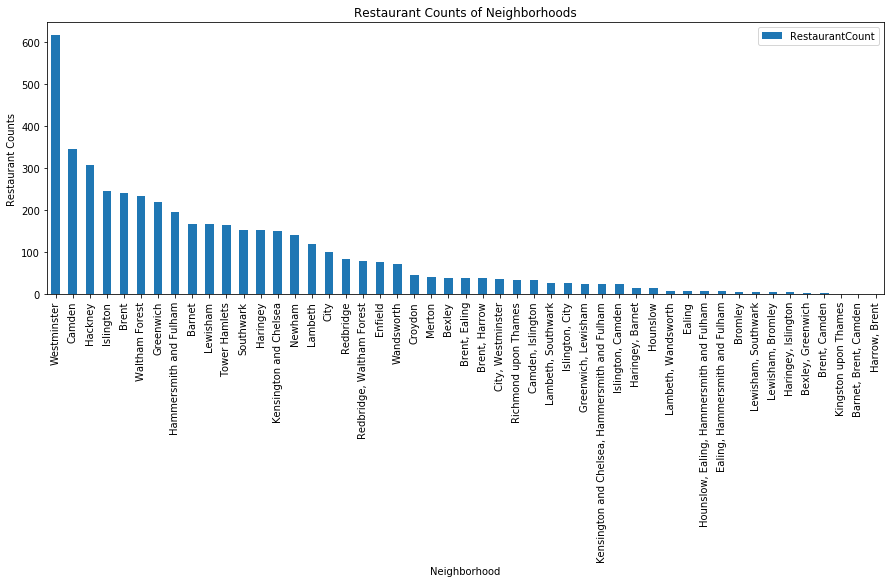

In [35]:
df_rest_counts=df_rest_counts.sort_values(by=['RestaurantCount'],ascending=False)
df_rest_counts[['RestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [36]:
a=restaurant
a.groupby(['Neighbourhood', 'Venue Category']).size()

Neighbourhood                                   Venue Category               
Barnet                                          Burger Joint                      3
                                                Café                             25
                                                Caribbean Restaurant              1
                                                Caucasian Restaurant              2
                                                Chinese Restaurant                2
                                                Coffee Shop                      33
                                                Dumpling Restaurant               1
                                                English Restaurant                1
                                                Ethiopian Restaurant              3
                                                Fast Food Restaurant              6
                                                Hunan Restaurant                  

In [37]:
restaurant.tail()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Category
11549,Greenwich,51.503129,-0.108025,Union Street Cafe,Italian Restaurant
11553,Greenwich,51.503129,-0.108025,Coconut,Thai Restaurant
11560,Hammersmith and Fulham,51.515085,-0.242696,Costa Coffee,Coffee Shop
11562,Hammersmith and Fulham,51.515085,-0.242696,Wok's Cooking,Chinese Restaurant
11567,Hammersmith and Fulham,51.515085,-0.242696,Chinese Chef,Chinese Restaurant
